# Es posible encontrar un modelo que ayude a distinguir de manera eficiente los buenos de los malos pagadores?

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import files
import seaborn as sns
from matplotlib import style
from mlxtend.plotting import plot_learning_curves
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
style.use('ggplot')

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def Benchmark(models,X,y,scoring='roc_auc',cv=3):
  names,roc,cv_min,cv_max,cv_score=[],[],[],[],[]
  
  for model in models:
    names.append(str(model)[:str(model).find('(')])
  
  for model in models:
    model.fit(X,y)
    cv_score.append(np.mean(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
    cv_min.append(np.min(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
    cv_max.append(np.max(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
  resultados=pd.DataFrame(data={'CV Score':cv_score,'CV Min':cv_min,'CV max':cv_max},index=names)
  resultados.plot.barh(figsize=(12,7))
  return resultados


In [0]:
from sklearn.linear_model import LogisticRegression
def StackingClassifier(X,y,models,stacker=LogisticRegression(),return_data=True):
  names,ls=[],[]
  predictions=pd.DataFrame()
  for model in models:
    names.append(str(model)[:str(model).find('(')])
  
  for i,model in enumerate(models):
    model.fit(X,y)
    ls=model.predict_proba(X)[:,1]
    predictions[names[i]]=ls
  if return_data:
    return predictions
  else:
    return stacker.fit(predictions,y)

In [0]:
def ROCs(models,X,y,test_size=.3):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size)
    ls=[]
    names=[]
    
    for model in models:
        names.append(str(model)[:str(model).find('(')])
    
    plt.figure(figsize=(12,7))
    for name,model in zip(names,models):
        model.fit(X_train,y_train)
        escore=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
        fpr,tpr,thresshold=roc_curve(y_test,model.predict_proba(X_test)[:,1])
        ls.append(escore)
        plt.plot(fpr,tpr,label=name+ ': '+ str(round(escore,4)))
    plt.plot([0,1],[0,1],'--',color='red',label='Threshold')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')

In [0]:
def FancyImputer(method,df,colum):
  aux=df.dropna(axis=0,how='any')
  X=aux.drop(colum,axis=1)
  y=aux[colum]
  method.fit(X,y)
  Ximp=df[df[colum].isnull()].drop(colum,axis=1).fillna(df.mean())
  return method.predict(Ximp)

In [0]:
def Calibrated_classifier(models,method='sigmoid',return_names=True):
  calibrated,names=[],[]
  for model in models:
    names.append(str(model)[:str(model).find('(')])
  
  for model in models:
    clf=CalibratedClassifierCV(base_estimator=model,method=method)
    calibrated.append(clf)
  if return_names:
    return zip(names,calibrated)
  else: 
    return calibrated

In [0]:
def Class_balanced(df,target,mayority_class=0):
  mayority=df[df[target]==mayority_class].sample(df[df[target] !=mayority_class].shape[0])
  minority=df[df[target] != mayority_class]
  balanced=pd.concat([minority,mayority])
  balanced.reset_index(inplace=True)
  return balanced
  

In [0]:
uploaded=files.upload()

Saving cs-training.csv to cs-training.csv


In [0]:
df = pd.read_csv('cs-training.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


In [0]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [0]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


# Data visualization

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

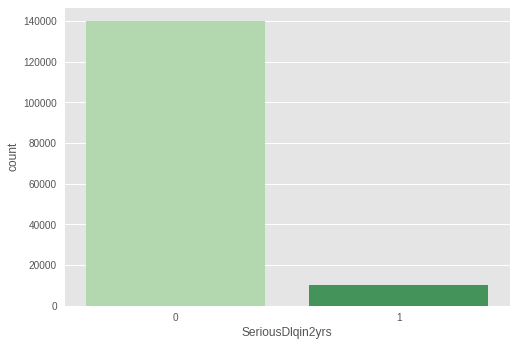

In [0]:
sns.countplot(df.SeriousDlqin2yrs,palette='Greens')
df.SeriousDlqin2yrs.value_counts(normalize=False)

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


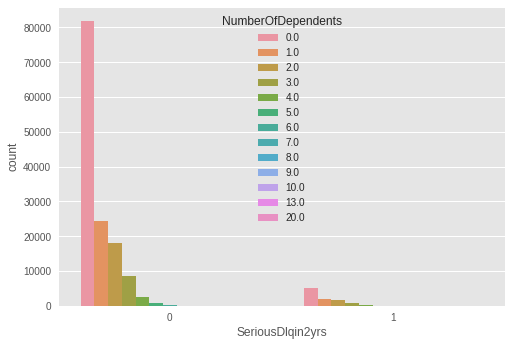

In [0]:
sns.countplot(df.SeriousDlqin2yrs,hue=df.NumberOfDependents)

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5,1,'Age')

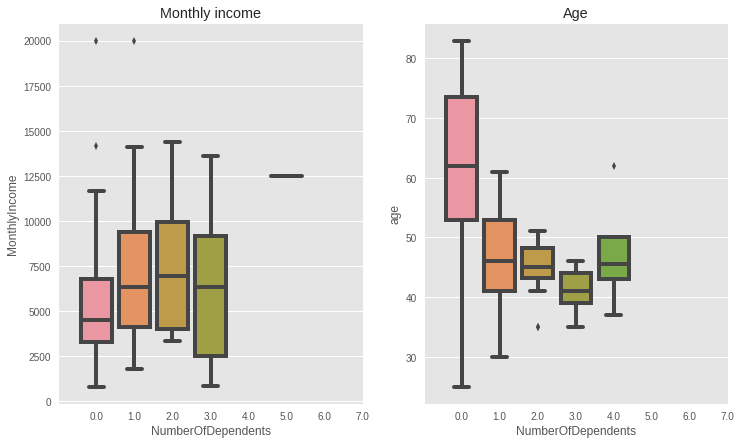

In [0]:
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
sns.boxplot(x=df.NumberOfDependents,y=df.MonthlyIncome.sample(100),linewidth=4)
plt.xlim([-1,7])
plt.title('Monthly income')

plt.subplot(1,2,2)
sns.boxplot(x=df.NumberOfDependents,y=df.age.sample(100),linewidth=4)
plt.xlim([-1,7])
plt.title('Age')

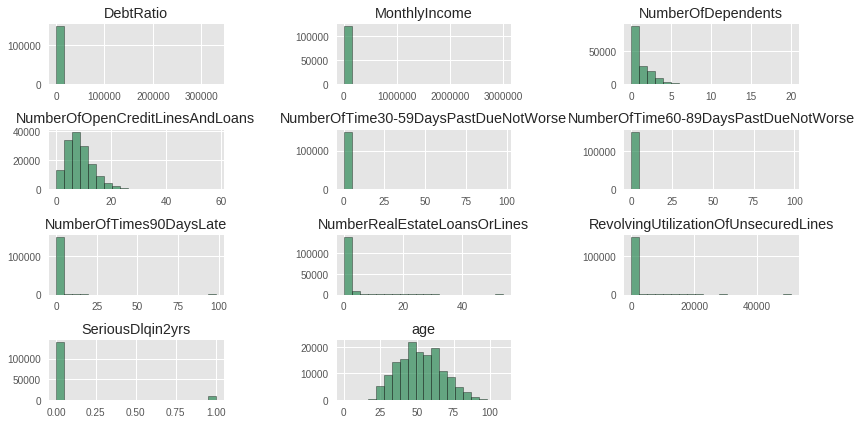

In [0]:
df.hist(bins=20,color='seagreen',edgecolor='black',alpha=.7,figsize=(12,6))
plt.tight_layout()

In [0]:
pd.crosstab(index=df.SeriousDlqin2yrs,columns=df.NumberOfDependents,margins=True,normalize=True)

NumberOfDependents,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,13.0,20.0,All
SeriousDlqin2yrs,,,,,,,,,,,,,,
0,0.567467,0.1643,0.120653,0.057673,0.01710,0.004540,0.000893,0.000307,0.000147,0.000033,0.000033,0.000007,0.000007,0.93316
1,0.034860,0.0130,0.010747,0.005593,0.00198,0.000453,0.000160,0.000033,0.000013,0.000000,0.000000,0.000000,0.000000,0.06684
All,0.602327,0.1773,0.131400,0.063267,0.01908,0.004993,0.001053,0.000340,0.000160,0.000033,0.000033,0.000007,0.000007,1.00000


In [0]:
from scipy import stats
stats.chi2_contingency(pd.crosstab(index=df.SeriousDlqin2yrs,columns=df.NumberOfDependents,margins=False))

(365.2603178750635,
 8.421680157400903e-71,
 12,
 array([[8.43100728e+04, 2.48173902e+04, 1.83925836e+04, 8.85568840e+03,
         2.67070392e+03, 6.98936840e+02, 1.47439280e+02, 4.75911600e+01,
         2.23958400e+01, 4.66580000e+00, 4.66580000e+00, 9.33160000e-01,
         9.33160000e-01],
        [6.03892716e+03, 1.77760980e+03, 1.31741640e+03, 6.34311600e+02,
         1.91296080e+02, 5.00631600e+01, 1.05607200e+01, 3.40884000e+00,
         1.60416000e+00, 3.34200000e-01, 3.34200000e-01, 6.68400000e-02,
         6.68400000e-02]]))

In [0]:
df.columns

Index([u'SeriousDlqin2yrs', u'RevolvingUtilizationOfUnsecuredLines', u'age',
       u'NumberOfTime30-59DaysPastDueNotWorse', u'DebtRatio', u'MonthlyIncome',
       u'NumberOfOpenCreditLinesAndLoans', u'NumberOfTimes90DaysLate',
       u'NumberRealEstateLoansOrLines',
       u'NumberOfTime60-89DaysPastDueNotWorse', u'NumberOfDependents'],
      dtype='object')

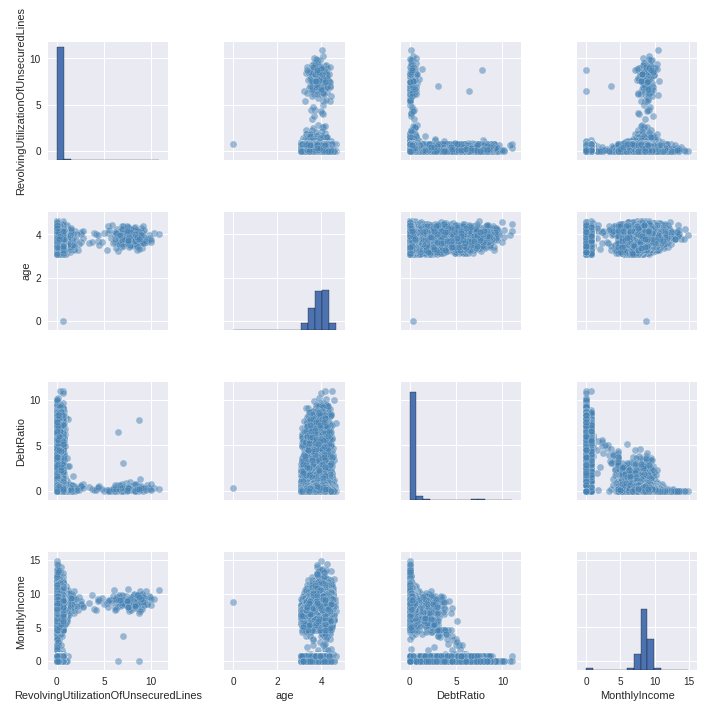

In [0]:
sns.pairplot(np.log(df[['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome']]+1).dropna(axis=0,how='any'),
             plot_kws=dict(color='steelblue',alpha='.5'),diag_kws=dict(bins=15,edgecolor='black'))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Log Monthlty income')

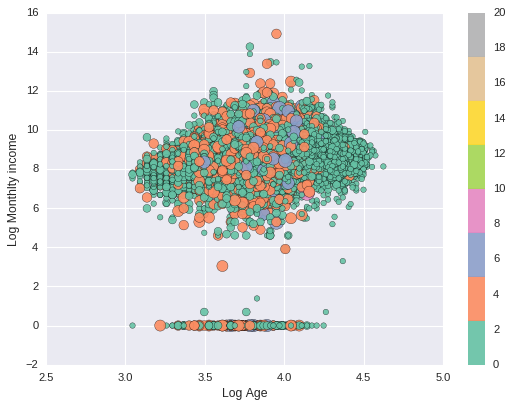

In [0]:
plt.scatter(data=df,x=np.log(df.age),y=np.log(df.MonthlyIncome),alpha=.9,
            s=df['NumberOfDependents']*25,c=df.NumberOfDependents,cmap='Set2')
plt.colorbar()
plt.xlabel('Log Age')
plt.ylabel('Log Monthlty income')

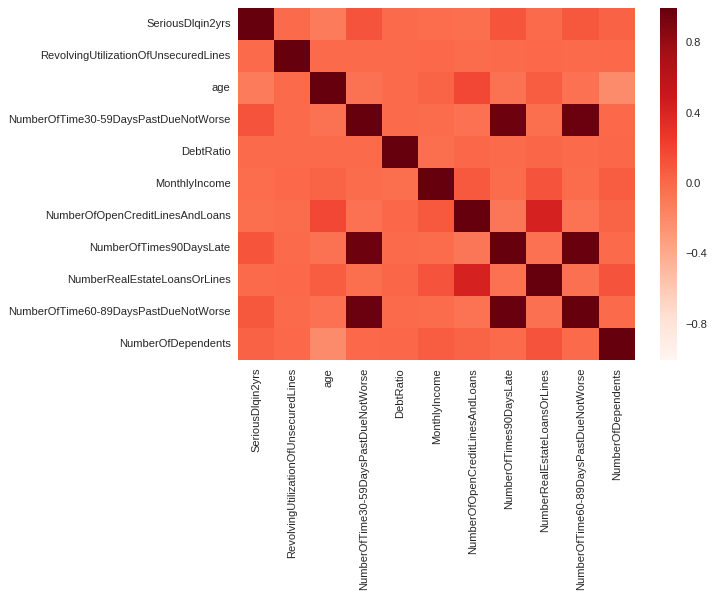

In [0]:
#zeros=np.zeros_like(df.corr())
#code=np.triu_indices_from(zeros)
#zeros[code]=True
sns.heatmap(df.dropna(axis=0,how='any').corr(),cmap='Reds')

In [0]:
from sklearn.decomposition import IncrementalPCA,PCA
from sklearn.preprocessing import StandardScaler

In [0]:
X2D=IncrementalPCA(n_components=2).fit_transform(StandardScaler().fit_transform(df.drop(['SeriousDlqin2yrs'],axis=1).dropna(axis=0,how='any')))

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
ipca=IncrementalPCA().fit(df.drop(['SeriousDlqin2yrs'],axis=1).dropna(axis=0,how='any'))

In [0]:
ipca.explained_variance_ratio_

array([9.98810873e-01, 8.68900863e-04, 3.18907432e-04, 1.00894822e-06,
       1.72891396e-07, 1.23177551e-07, 6.31146373e-09, 4.83002326e-09,
       1.53605721e-09, 5.87491060e-10])

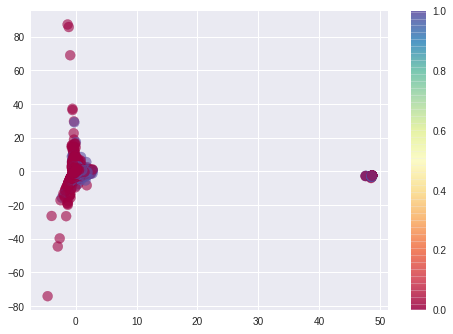

In [0]:
plt.scatter(X2D[:,0],X2D[:,1],c=df.dropna(axis=0,how='any').SeriousDlqin2yrs,s=100,alpha=.6,cmap='Spectral')
plt.legend(loc='best')
plt.colorbar()

# Data Imputing

In [0]:
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.decomposition import PCA

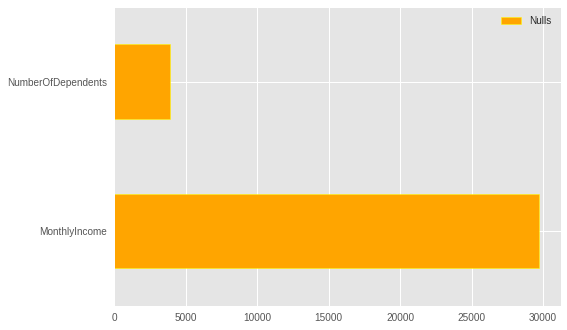

In [0]:
ls,names=[],[]
for i,col in enumerate(df.columns):
  if df[col].isnull().sum() != 0:
    ls.append(df[col].isnull().sum())
    names.append(col)
pd.DataFrame({'Nulls':ls},index=names).plot.barh(color='orange',edgecolor='yellow')


In [0]:
%%time
MonthlyIncome_imp=FancyImputer(KNeighborsRegressor(weights='distance',algorithm='auto'),df,'MonthlyIncome')

CPU times: user 645 ms, sys: 18 ms, total: 663 ms
Wall time: 667 ms


In [0]:
%%time
NumberOfDependents_imp=FancyImputer(KNeighborsClassifier(weights='distance',algorithm='auto'),df,'NumberOfDependents')

CPU times: user 460 ms, sys: 1.75 ms, total: 462 ms
Wall time: 464 ms


In [0]:
df.NumberOfDependents[df.NumberOfDependents.isnull()]=NumberOfDependents_imp
df.MonthlyIncome[df.MonthlyIncome.isnull()]=MonthlyIncome_imp

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Outliyers detection

In [0]:
from sklearn.neighbors import LocalOutlierFactor

In [0]:
lof=LocalOutlierFactor(algorithm='auto',contamination='auto').fit(df.drop(['SeriousDlqin2yrs'],axis=1))
outliyers=lof.fit_predict(df.drop(['SeriousDlqin2yrs'],axis=1))

In [0]:
np.unique(outliyers,return_counts=True)

(array([-1,  1]), array([  6769, 143231]))

In [0]:
df['outliyers']=outliyers

In [0]:
pd.crosstab(index=df.SeriousDlqin2yrs,columns=df.outliyers,margins=True,normalize=False)

outliyers,-1,1,All
SeriousDlqin2yrs,,,
0,5928,134046,139974
1,841,9185,10026
All,6769,143231,150000


# Modelación

In [0]:
X=df.drop(['SeriousDlqin2yrs'],axis=1)
Xscaled=make_pipeline(StandardScaler(),PCA(),MinMaxScaler()).fit_transform(X)
y=df.SeriousDlqin2yrs
X_train,X_test,y_train,y_test=train_test_split(Xscaled,y,test_size=.2)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

In [0]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image

In [0]:
clf=DecisionTreeClassifier(criterion='entropy',class_weight='balanced',max_features='sqrt').fit(X_train,y_train)
print('Base classifier roc_auc score: %.3f \n Our best classifier must get something atleast above \n good luck!!' % roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))

Base classifier roc_auc score: 0.604 
 Our best classifier must get something atleast above 
 good luck!!


([1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9999950337210342,
  0.9999910642480564],
 [0.5969124881027544,
  0.584284474919193,
  0.5919872051603419,
  0.593145566921417,
  0.5987026701659489,
  0.6024430875825739,
  0.5903226214932574,
  0.6015971757588322,
  0.598426736526664,
  0.6085617761527371])

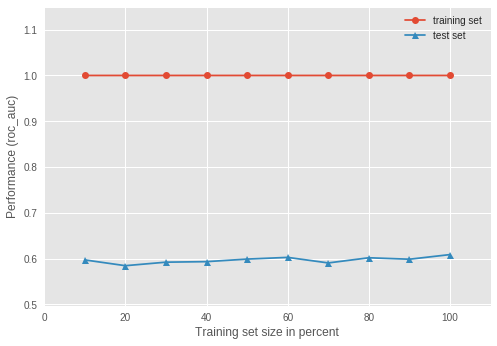

In [0]:
plot_learning_curves(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,clf=clf,scoring='roc_auc',style='ggplot',print_model=False)

### Base classifier visualization

In [0]:
#dot_image=export_graphviz(decision_tree=clf,out_file=None,feature_names=X.columns)
#data=pydotplus.graph_from_dot_data(dot_image)
#Image(data.create_png())

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


                     CV Min  CV Score    CV max
nnet               0.815429  0.823403  0.828456
random forest      0.794088  0.798945  0.804448
ada boost          0.819316  0.823967  0.829124
gradient boosting  0.823601  0.828486  0.833183
svm                0.727078  0.730385  0.737686
CPU times: user 1h 16min 30s, sys: 38min 33s, total: 1h 55min 3s
Wall time: 1h 5min 56s


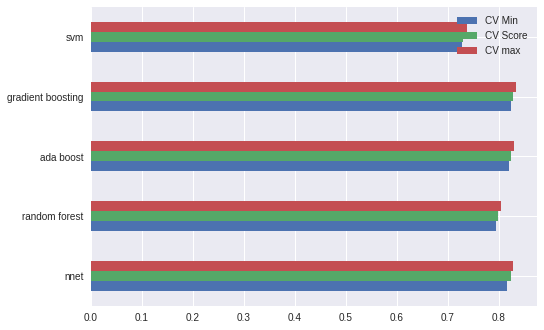

In [0]:
%%time
cv_score,cv_min,cv_max=[],[],[]
SVM=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),method='sigmoid')
models=[MLPClassifier(),RandomForestClassifier(n_estimators=100),AdaBoostClassifier(),GradientBoostingClassifier(),SVM]
names=['nnet','random forest','ada boost','gradient boosting','svm']
for model in models:
  model.fit(X_train,y_train)
  cv_score.append(np.mean(cross_val_score(X=Xscaled,y=y,estimator=model,scoring='roc_auc')))
  cv_min.append(np.min(cross_val_score(X=Xscaled,y=y,estimator=model,scoring='roc_auc')))
  cv_max.append(np.max(cross_val_score(X=Xscaled,y=y,estimator=model,scoring='roc_auc')))
resultados=pd.DataFrame(data={'CV Score':cv_score,'CV Min':cv_min,'CV max':cv_max},index=names)

resultados.plot.barh()
print resultados

In [0]:
SVM=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),method='sigmoid')
models=[MLPClassifier(),RandomForestClassifier(n_estimators=100),AdaBoostClassifier(),GradientBoostingClassifier(),SVM]

                       Test     Train
Voting             0.862033  0.979536
nnet               0.831515  0.832344
random forest      0.837648  1.000000
ada boost          0.852653  0.862627
gradient boosting  0.860377  0.869216
CPU times: user 10min 31s, sys: 2min 28s, total: 13min
Wall time: 9min 55s


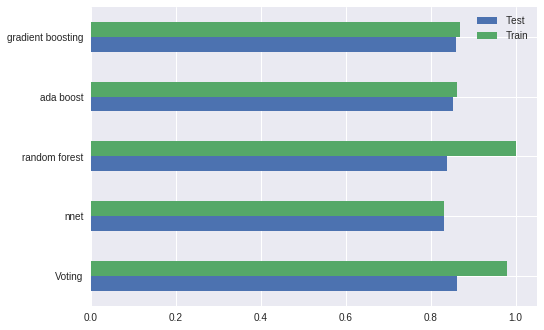

In [0]:
%%time
train,test=[],[]

voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(n_estimators=1000)),
        ('ada',AdaBoostClassifier()),('gbd',GradientBoostingClassifier(loss='deviance')),('gbe',GradientBoostingClassifier(loss='exponential'))]

SVM=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),method='sigmoid')

models=[VotingClassifier(estimators=voting,voting='soft'),nnet,
        RandomForestClassifier(n_estimators=100),AdaBoostClassifier(),GradientBoostingClassifier(loss='deviance')]

names=['Voting','nnet','random forest','ada boost','gradient boosting']
for model in models:
  model.fit(X_train,y_train)
  train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
  test.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
resultados=pd.DataFrame(data={'Train':train,'Test':test},index=names) 

resultados.plot.barh()
print resultados

In [0]:
uploaded=files.upload()

Saving cs-test.csv to cs-test.csv


In [0]:
test=pd.read_csv('cs-test.csv')

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
Unnamed: 0                              101503 non-null int64
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(7)
memory usage: 9.3 MB


In [0]:
test.drop(['SeriousDlqin2yrs','Unnamed: 0'],axis=1,inplace=True)

In [0]:
MonthlyIncome_imp=FancyImputer(KNeighborsRegressor(weights='distance'),test,'MonthlyIncome')
NumberOfDependents_imp=FancyImputer(KNeighborsClassifier(weights='distance'),test,'NumberOfDependents')
test.NumberOfDependents[test.NumberOfDependents.isnull()]=NumberOfDependents_imp
test.MonthlyIncome[test.MonthlyIncome.isnull()]=MonthlyIncome_imp

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 10 columns):
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           101503 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      101503 non-null float64
dtypes: float64(4), int64(6)
memory usage: 7.7 MB


In [0]:
lof=LocalOutlierFactor(algorithm='auto',contamination='auto').fit(test)
outliyers=lof.fit_predict(test)
test['outliyers']=outliyers

In [0]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(n_estimators=100)),('ada',AdaBoostClassifier()),('gb',GradientBoostingClassifier())]
clf=VotingClassifier(voting='soft',estimators=voting).fit(X,y)

In [0]:
final_pred=pd.DataFrame(clf.predict_proba(test))

In [0]:
final_pred.to_csv('final_pred.csv')

In [0]:
files.download('final_pred.csv')

# Intento 2: Clases balanceadas

In [0]:
df_balanced=Class_balanced(df,'SeriousDlqin2yrs')
df_balanced.drop(['index'],axis=1,inplace=True)

In [0]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Data columns (total 12 columns):
SeriousDlqin2yrs                        20052 non-null int64
RevolvingUtilizationOfUnsecuredLines    20052 non-null float64
age                                     20052 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    20052 non-null int64
DebtRatio                               20052 non-null float64
MonthlyIncome                           20052 non-null float64
NumberOfOpenCreditLinesAndLoans         20052 non-null int64
NumberOfTimes90DaysLate                 20052 non-null int64
NumberRealEstateLoansOrLines            20052 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    20052 non-null int64
NumberOfDependents                      20052 non-null float64
outliyers                               20052 non-null int64
dtypes: float64(4), int64(8)
memory usage: 1.8 MB


In [0]:
df_balanced.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,20052.0,0.500000,0.500012,0.0,0.000000,0.500000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,20052.0,5.145299,164.874154,0.0,0.071617,0.431357,0.939019,12369.0
age,20052.0,49.298125,14.301627,21.0,39.000000,48.000000,59.000000,103.0
NumberOfTime30-59DaysPastDueNotWorse,20052.0,1.369689,8.813905,0.0,0.000000,0.000000,1.000000,98.0
DebtRatio,20052.0,367.082129,3737.743111,0.0,0.180996,0.394635,0.903953,329664.0
MonthlyIncome,20052.0,5075.728193,6979.004568,0.0,1900.000000,4083.000000,6800.000000,304000.0
NumberOfOpenCreditLinesAndLoans,20052.0,8.155346,5.367141,0.0,4.000000,7.000000,11.000000,57.0
NumberOfTimes90DaysLate,20052.0,1.146768,8.818314,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,20052.0,0.998205,1.253431,0.0,0.000000,1.000000,2.000000,29.0
NumberOfTime60-89DaysPastDueNotWorse,20052.0,1.014213,8.797952,0.0,0.000000,0.000000,0.000000,98.0


In [0]:
pd.crosstab(index=df_balanced.SeriousDlqin2yrs,columns=df_balanced.outliyers,margins=True)

outliyers,-1,1,All
SeriousDlqin2yrs,,,
0,416,9610,10026
1,841,9185,10026
All,1257,18795,20052


In [0]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
X=make_pipeline(StandardScaler(),PCA(),MinMaxScaler()).fit_transform(df_balanced.drop(['SeriousDlqin2yrs'],axis=1))
y=df_balanced.SeriousDlqin2yrs

In [0]:
Calibrated=Calibrated_classifier(models=[RandomForestClassifier(n_estimators=1000),
                                         XGBClassifier(),
                                         AdaBoostClassifier(),
                                         GradientBoostingClassifier(loss='exponential'),
                                         MLPClassifier()])

In [0]:
models=[VotingClassifier(estimators=Calibrated,voting='soft'),
        XGBClassifier(),
        RandomForestClassifier(n_estimators=250)]

CPU times: user 23min 58s, sys: 3min 13s, total: 27min 12s
Wall time: 23min 8s


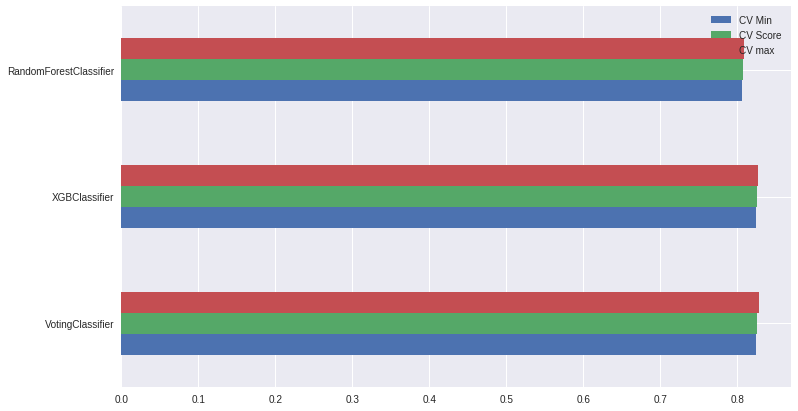

In [0]:
%%time
resultados=Benchmark(models=models,X=X,y=y)

In [0]:
resultados  

,CV Min,CV Score,CV max
VotingClassifier,0.822077,0.828080,0.837838
XGBClassifier,0.819491,0.826679,0.836519
RandomForestClassifier,0.804241,0.809354,0.816937
AdaBoostClassifier,0.646918,0.666866,0.673698


In [0]:
#https://stackoverflow.com/questions/46580199/hyperparameter-in-voting-classifier
from sklearn.model_selection import RandomizedSearchCV

In [0]:
clfs=[('RandomForestClassifier',RandomForestClassifier(n_estimators=500)),('AdaBoostClassifier',AdaBoostClassifier()),
      ('MLPClassifier',MLPClassifier()),('LogisticRegression',LogisticRegression())
      ,('XGBClassifier',XGBClassifier()),('GradientBoostingClassifier',GradientBoostingClassifier())]
voting=VotingClassifier(clfs,voting='soft')

In [0]:
voting

VotingClassifier(estimators=[('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [0]:
params={'MLPClassifier__activation':['identity', 'logistic', 'tanh', 'relu'],'MLPClassifier__alpha':np.arange(.0001,.1,.01),
        'LogisticRegression__C':np.arange(.0001,1,.01),
        'XGBClassifier__n_estimators':[100,200,300,400,500],'XGBClassifier__max_depth':[3,5,7,9,11,15],
        'GradientBoostingClassifier__loss':['deviance', 'exponential']}
grid=RandomizedSearchCV(estimator=voting,param_distributions=params,scoring='roc_auc',cv=3)

In [0]:
%%time
grid.fit(X,y)

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
grid.best_params_

{'GradientBoostingClassifier__loss': 'deviance',
 'LogisticRegression__C': 0.9401,
 'MLPClassifier__activation': 'relu',
 'MLPClassifier__alpha': 0.0801,
 'XGBClassifier__max_depth': 3,
 'XGBClassifier__n_estimators': 500}

In [0]:
voting=grid.best_estimator_
models=[voting,
        XGBClassifier(),
        RandomForestClassifier(n_estimators=500),
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier())]

CPU times: user 12min 26s, sys: 1min 50s, total: 14min 16s
Wall time: 11min 57s


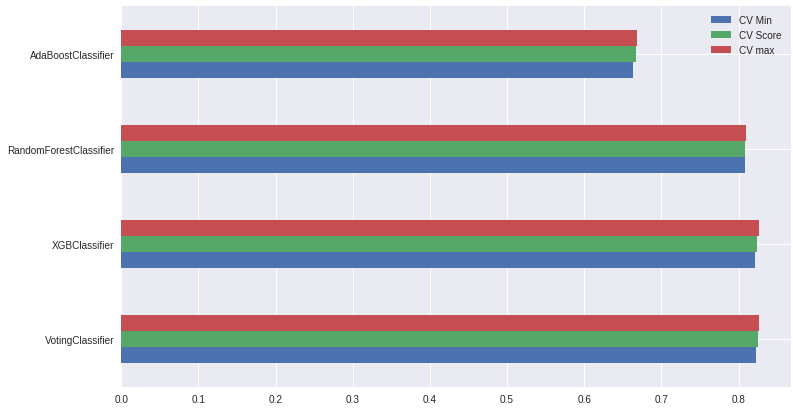

In [0]:
%%time
resultados=Benchmark(models=models,X=X,y=y)

In [0]:
resultados

,CV Min,CV Score,CV max
VotingClassifier,0.824417,0.826093,0.828162
XGBClassifier,0.824582,0.825238,0.826333
RandomForestClassifier,0.805955,0.807427,0.808593


#Intento 3: Stacking Classifier
###Antes de entrenar a nuestro Stacking es necesario calibrarlo mediante "Platt scaling para que los valores sobre los cuales nuestro meta classifier va a entrenar sean probabilidades"

In [0]:
%%time
models=[KNeighborsClassifier(weights='distance'),
        GaussianNB(),SGDClassifier(loss='hinge'),XGBClassifier()]
calibrated_models=Calibrated_classifier(models,return_names=False)
meta=LogisticRegression()
stacker=StackingCVClassifier(classifiers=calibrated_models,meta_classifier=meta,use_probas=True).fit(X.values,y.values)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration

CPU times: user 1min 2s, sys: 5.13 s, total: 1min 7s
Wall time: 1min


In [0]:
final_pred=pd.DataFrame(stacker.predict_proba(test))

In [0]:
final_pred.to_csv('stacker.csv')

In [0]:
files.download('stacker.csv')